In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from functools import partial
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

os.environ['CUDA_VISIBLE_DEVICES'] = str(2)

import sys
THRID_PARTY_LIB_PATH = (
    "../../",
    "/data/huengchi/Research/QuestEval",
    "/data/huengchi/.bin/anaconda3/envs/torch-2.1-py-3.10/lib/python3.10/site-packages",
)
for path in THRID_PARTY_LIB_PATH:
    path = os.path.abspath(path)
    if path not in sys.path:
        sys.path.insert(0, path)
    else:
        sys.path.remove(path)
        sys.path.insert(0, path)

from utils.metrics_predefined import (
    # FactKBMetric,
    # QuestEvalMetric,
    SummaCMetric,
)
from utils.utils import make_df_id_column, make_df_src_column

In [3]:
test_data = pd.read_json('//data/huengchi/Datasets/MEDIQA2021/Task3/dev.json', dtype=False)
# gen_data = 
id_spec = "study_id, subject_id"
metric_src_spec = "findings, background"
metric_tgt_spec = "impression"

In [4]:
test_data = test_data.apply(partial(make_df_id_column, id_spec=id_spec),
                            axis=1)
test_data = test_data.apply(partial(make_df_src_column, src_spec=metric_src_spec),
                            axis=1)
test_data['tgt'] = test_data[metric_tgt_spec]
test_data = test_data[['id', 'src', 'tgt']]
test_data

,id,src,tgt
0,51319575_14895513,Heart size is normal. The mediastinal and hila...,No acute cardiopulmonary abnormality.
1,55445311_12837356,Semi-upright portable view of the chest demons...,"ET tube terminates 2 cm above the carina, retr..."
2,55362942_10222191,Stability of the severe bilateral pleural effu...,There is no significant change since the previ...
3,54120968_14898984,In comparison to the chest radiograph obtained...,"Unchanged, mild pulmonary edema. No radiograph..."
4,56757236_18173974,"There is no focal consolidation, pleural effus...",No evidence of acute pulmonary process. Modera...
...,...,...,...
1995,51118387_10053918,The lungs are clear without focal consolidatio...,No acute cardiopulmonary process.
1996,53706588_11209060,Frontal and lateral views of the chest were ob...,No acute cardiopulmonary process.
1997,53987789_12645334,No change in the position of the bilateral pig...,Increased opacification of the left lower lung...
1998,52230820_12632853,One portable AP upright view of the chest. Mod...,Increased right pleural effusion and mild inte...


In [5]:
# factkb_scorer = FactKBMetric()
# questeval_scorer = QuestEvalMetric()
summac_scorer = SummaCMetric()

loading preloaded_summac_scorer_model...


--2024-04-09 11:30:27--  https://github.com/tingofurro/summac/raw/master/summac_conv_vitc_sent_perc_e.bin
Connecting to 10.249.42.241:41122... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tingofurro/summac/master/summac_conv_vitc_sent_perc_e.bin [following]
--2024-04-09 11:30:28--  https://raw.githubusercontent.com/tingofurro/summac/master/summac_conv_vitc_sent_perc_e.bin
Connecting to 10.249.42.241:41122... connected.
Proxy request sent, awaiting response... 

<All keys matched successfully>


200 OK
Length: 1811 (1.8K) [application/octet-stream]
Saving to: ‘summac_conv_vitc_sent_perc_e.bin’

     0K .                                                     100% 14.8M=0s

2024-04-09 11:30:28 (14.8 MB/s) - ‘summac_conv_vitc_sent_perc_e.bin’ saved [1811/1811]



In [7]:
def compute_metric(row):
    # factkb_dict = factkb_scorer([row['src']], [row['tgt']])
    # row['factkb'] = factkb_dict['score_details_per_sample']['factkb'][0]

    # questeval_dict = questeval_scorer([row['src']], [row['tgt']])
    # row['questeval'] = questeval_dict['score_details_per_sample']['questeval'][0]

    summac_dict = summac_scorer([row['src']], [row['tgt']])
    row['summac_zs'] = summac_dict['score_details_per_sample']['SummaC-ZS'][0]
    row['summac_conv'] = summac_dict['score_details_per_sample']['SummaC-Conv'][0]

    return row

In [8]:
tqdm.pandas()
test_data = test_data.progress_apply(compute_metric,
                                     axis=1)

  0%|          | 0/2000 [00:00<?, ?it/s]

/data/huengchi/.bin/anaconda3/envs/torch-2.1-py-3.10/lib/python3.10/site-packages/summac/model_summac.py:298: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  histograms = torch.FloatTensor(histograms).to(self.device)


{'SummaC-ZS': -0.505126953125, 'SummaC-Conv': 0.31903013586997986, 'score_details_per_sample': {'SummaC-ZS': [-0.505126953125], 'SummaC-Conv': [0.31903013586997986]}}


summac_zs 	 -0.1886760836234168
summac_conv 	 0.3889666463285685


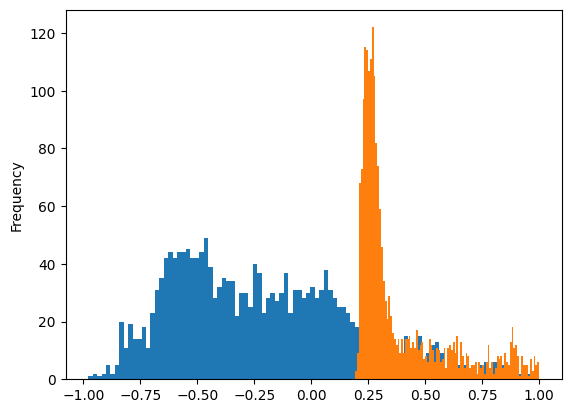

In [11]:
for k in ('summac_zs', 'summac_conv'):
    print(k, '\t', np.mean(test_data[k]))
    test_data[k].plot.hist(bins=100)